In [133]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect, func

In [134]:
import numpy as np
import pandas as pd

In [135]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [136]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [137]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [138]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [139]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [140]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [141]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [142]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [143]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [144]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [145]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [146]:
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [147]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores
year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23'  ).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
dateStart = '2016-08-23'
dateEnd = '2017-08-23'
df_1 = pd.DataFrame (year_prcp, columns=['date', 'precipitation'])
df_1.set_index('date', inplace=True)
df_1.sort_index()
df_1.dropna()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


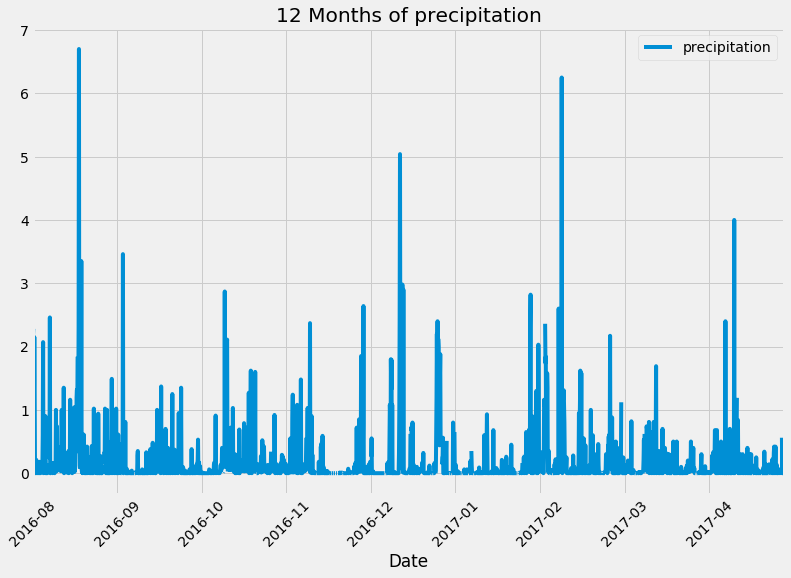

In [148]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = df_1.plot(figsize=(12,8))
plt.legend()
plt.title("12 Months of precipitation")
xTickLabel = np.arange(np.datetime64(dateStart), np.datetime64(dateEnd), np.timedelta64(1, 'M'), dtype='datetime64[M]')
ax.set_xticklabels(xTickLabel,rotation=45)
ax.set_xlabel('Date')
plt.show()

In [149]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_1.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [150]:
# Design a query to show how many stations are available in this dataset?
numstations = session.query(Station.id).count()
print('There are %i stations in this dataset'%numstations)

There are 9 stations in this dataset


In [151]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Three_stations = session.query(Measurement.station,
    func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).limit(3).\
    all()

for station in Three_stations:
    print (f'Station {station[0]} has a total count of {station[1]}.')


Station USC00519281 has a total count of 2772.
Station USC00519397 has a total count of 2724.
Station USC00513117 has a total count of 2709.


In [152]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
s = Three_stations[0][0]
sel = [Measurement.station,    
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]
most_active_station_sel = session.query(*sel).\
    filter(Measurement.station == most_active_station)

print(
f"Most active station: {info_most_active_station[0][0]}\n\
Minimum temperature: {info_most_active_station[0][1]}\n\
Maximum temperature: {info_most_active_station[0][2]}\n\
Average temperature: {info_most_active_station[0][3]}"
     )

Most active station: USC00519281
Minimum temperature: 54.0
Maximum temperature: 85.0
Average temperature: 71.66378066378067


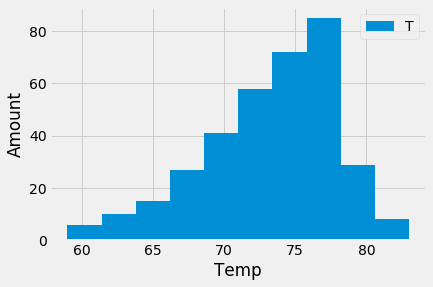

In [157]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Last_12months = (dt.datetime.strptime(dateEnd, '%Y-%m-%d') - dt.timedelta(days=365)).date()
                 
histogram = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date > Last_12months).all()


temp_df = pd.DataFrame(histogram)
Last_12months
histogram
plt.hist(temp_df.tobs)
plt.legend('Tobs')
plt.ylabel('Amount')
plt.xlabel('Temp')
plt.show()



## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
